In [37]:
import pymc3 as pmc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
from datetime import datetime as dt

In [6]:
url = 'https://brasil.io/dataset/covid19/caso?format=csv'

dfcov = pd.read_csv(url)
dfcov.date = pd.to_datetime(dfcov.date, format = '%Y-%m-%d')
dfcov.date = dfcov.date.apply(lambda d: dt.date(d))
dfuf = dfcov.loc[(dfcov.place_type == 'state')]
dfuf = dfuf.sort_values(by = ['state', 'date'])

In [7]:
def reindex_by_date(df):
    dates = pd.date_range(dfcov.date.min(), dfcov.date.max())
    return df.reindex(dates).bfill().ffill()

dfuf = dfuf.set_index('date').groupby('state').apply(reindex_by_date).reset_index(0, drop=True)
dfuf = dfuf.reset_index().rename({'index' :'date'}, axis = 1)
dfuf['dif'] = dfuf.reset_index().groupby('state').confirmed.diff(periods = 1).fillna(0)

In [13]:
dftotal = dfuf.groupby('date').agg({'deaths' : 'sum', 'confirmed' : 'sum'}).reset_index()
dftotal = dftotal.sort_values('date', ascending = True)
dftotal = dftotal.set_index('date')

In [34]:
dftotal['growth'] = dftotal.confirmed.pct_change()
dftotal['growthd'] = dftotal.deaths.pct_change()
dftotal['elapsed'] = np.arange(0, dftotal.shape[0])

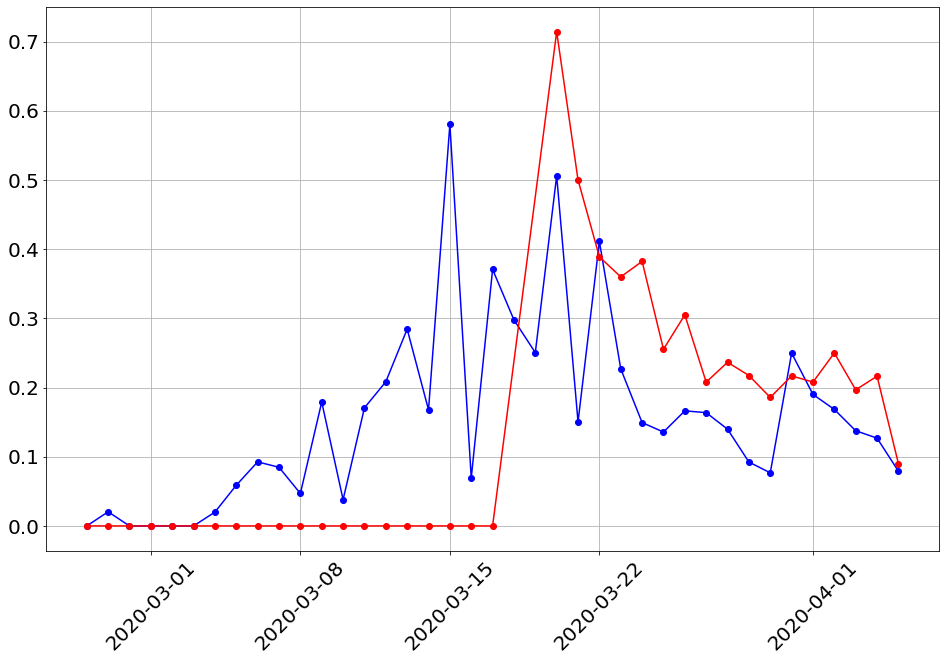

In [36]:
fig = plt.figure(figsize = (16, 10))

plt.plot(dftotal.growth, 'bo-')
plt.plot(dftotal.loc[dftotal.growthd < 1, 'growthd'], 'ro-')
plt.grid(True)
plt.xticks(rotation = 45)
plt.show()

## Modelo 1: taxa varia linearmente, 1 changepoint

In [39]:
with pmc.Model() as model1:
    
    # Changepoint
    t0 = pmc.DiscreteUniform('t0', lower = 2, upper = dftotal.shape[0] - 2)
    
    # Reta 1
    a1 = pmc.Normal('a1', mu = 0, sigma = 3)
    b1 = pmc.Normal('b1', mu = 0, sigma = 3)
    
    # Reta 2
    a2 = pmc.Normal('a1', mu = 0, sigma = 3)
    b2 = pmc.Normal('b1', mu = 0, sigma = 3)    
    
    # Reta vigente
    a = pmc.Deterministic()

NameError: name 'model' is not defined